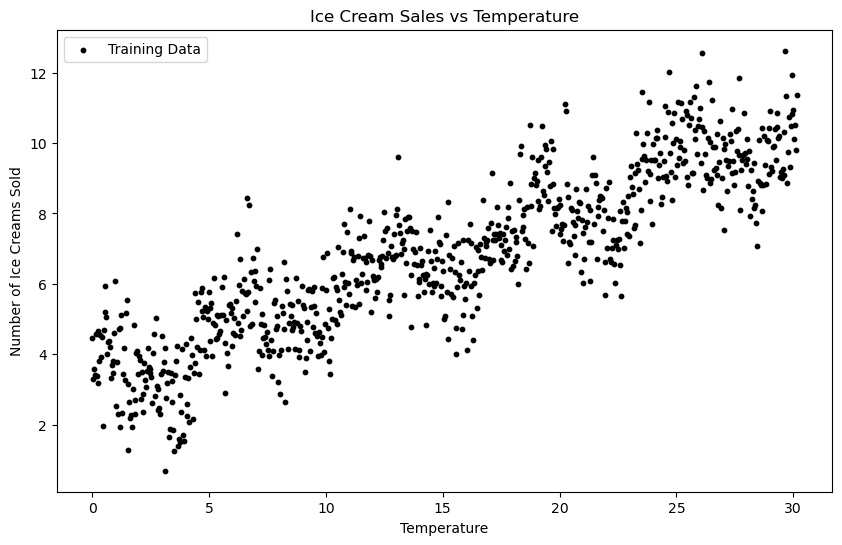

Estimated β̂0 (Intercept): 3.191037800253055
Estimated β̂1 (Slope): 0.23839763045936505

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     2840.
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          4.30e-265
Time:                        21:37:03   Log-Likelihood:                -1212.4
No. Observations:                 800   AIC:                             2429.
Df Residuals:                     798   BIC:                             2438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Function to load data
def load_data(filename):
    data = np.loadtxt(filename)
    x = data[:, 0]  # Temperature
    y = data[:, 1]  # Ice cream sales
    return x, y

def plot_data(x, y, title="Ice Cream Sales vs Temperature", color='black', label='Training Data'):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color=color, s=10, label=label)
    plt.xlabel('Temperature')
    plt.ylabel('Number of Ice Creams Sold')
    plt.title(title)
    plt.legend()
    plt.show()

def train_linear_model(x, y):
    x = pd.DataFrame(x)  # Fixing the reshaping
    model = LinearRegression()
    model.fit(x, y)
    beta0_hat = model.intercept_  # Intercept
    beta1_hat = model.coef_[0]    # Slope
    return model, beta0_hat, beta1_hat

def display_coefficients(beta0, beta1):
    print("Estimated β̂0 (Intercept):", beta0)
    print("Estimated β̂1 (Slope):", beta1)

def perform_ols_regression(x, y):
    x_with_const = sm.add_constant(x)
    ols_model = sm.OLS(y, x_with_const).fit()
    print("\nOLS Regression Summary:")
    print(ols_model.summary())

def add_nonlinear_features(x):
    epsilon = 1e-8  # Small constant to avoid log(0)
    features = pd.DataFrame({
        'x': x,
        'cos_x': np.cos(x),
        'log_x': np.log(x + epsilon),  # Avoid log(0)
        'cos_4x': np.cos(4 * x),
        'sin_3x': np.sin(3 * x),
        'sin_5x': np.sin(5 * x),
        'sin2x_cos2x': np.sin(2 * x) * np.cos(2 * x)
    })
    return features

def adjusted_r2_score(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def select_best_model(x, y):
    features = add_nonlinear_features(x)
    best_adj_r2 = -np.inf
    best_combination = None
    best_model = None
    
    for k in range(1, len(features.columns) + 1):
        for combo in combinations(features.columns, k):
            selected_features = features[list(combo)]
            model = LinearRegression()
            model.fit(selected_features, y)
            y_pred = model.predict(selected_features)
            
            adj_r2 = adjusted_r2_score(y, y_pred, len(y), len(combo))
            
            if adj_r2 > best_adj_r2:
                best_adj_r2 = adj_r2
                best_combination = combo
                best_model = model
    
    print(f"Best feature combination: {best_combination}")
    print(f"Highest Adjusted R^2: {best_adj_r2}")
    return best_model, best_combination, best_adj_r2

def get_regression_summary(x, y, best_features):
    features = add_nonlinear_features(x)
    selected_features = features[list(best_features)]
    selected_features_with_const = sm.add_constant(selected_features)
    ols_model = sm.OLS(y, selected_features_with_const).fit()
    print("\nOLS Regression Summary with Best Features:")
    print(ols_model.summary())

def train_lasso_ridge(x, y, best_features, alphas):
    features = add_nonlinear_features(x)
    selected_features = features[list(best_features)]
    
    lasso_results = []
    ridge_results = []
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(selected_features, y)
        lasso_pred = lasso.predict(selected_features)
        lasso_mse = mean_squared_error(y, lasso_pred)
        lasso_r2 = r2_score(y, lasso_pred)
        lasso_adj_r2 = adjusted_r2_score(y, lasso_pred, len(y), selected_features.shape[1])
        
        lasso_results.append((alpha, lasso_mse, lasso_r2, lasso_adj_r2, lasso.coef_))
        
        ridge = Ridge(alpha=alpha)
        ridge.fit(selected_features, y)
        ridge_pred = ridge.predict(selected_features)
        ridge_mse = mean_squared_error(y, ridge_pred)
        ridge_r2 = r2_score(y, ridge_pred)
        ridge_adj_r2 = adjusted_r2_score(y, ridge_pred, len(y), selected_features.shape[1])
        
        ridge_results.append((alpha, ridge_mse, ridge_r2, ridge_adj_r2, ridge.coef_))
    
    print("\nLasso Regression Results:")
    for alpha, mse, r2, adj_r2, coefs in lasso_results:
        print(f"Alpha: {alpha}, MSE: {mse:.4f}, R^2: {r2:.4f}, Adjusted R^2: {adj_r2:.4f}")
        print("Coefficients:", coefs)
    
    print("\nRidge Regression Results:")
    for alpha, mse, r2, adj_r2, coefs in ridge_results:
        print(f"Alpha: {alpha}, MSE: {mse:.4f}, R^2: {r2:.4f}, Adjusted R^2: {adj_r2:.4f}")
        print("Coefficients:", coefs)
    
    best_lasso = max(lasso_results, key=lambda x: x[3])
    best_ridge = max(ridge_results, key=lambda x: x[3])
    
    print("\nBest Lasso Model:")
    print(f"Alpha: {best_lasso[0]}, MSE: {best_lasso[1]:.4f}, R^2: {best_lasso[2]:.4f}, Adjusted R^2: {best_lasso[3]:.4f}")
    
    print("\nBest Ridge Model:")
    print(f"Alpha: {best_ridge[0]}, MSE: {best_ridge[1]:.4f}, R^2: {best_ridge[2]:.4f}, Adjusted R^2: {best_ridge[3]:.4f}")
    
    return best_lasso, best_ridge

if __name__ == "__main__":
    x_train, y_train = load_data('train.txt')
    
    plot_data(x_train, y_train)
    
    model, beta0_hat, beta1_hat = train_linear_model(x_train, y_train)
    display_coefficients(beta0_hat, beta1_hat)
    perform_ols_regression(x_train, y_train)
    
    best_model, best_features, best_adj_r2 = select_best_model(x_train, y_train)
    print("Model with highest Adjusted R^2 uses features:", best_features)
    get_regression_summary(x_train, y_train, best_features)
    
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]  # Different values for alpha
    best_lasso, best_ridge = train_lasso_ridge(x_train, y_train, best_features, alphas)
